In [1]:
import numpy as np
import pylab as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.particleFilter import *
from estimators.particleFilterEstimator import *

In [2]:
#Initialise the particle filter and create 3 random trajectory of 50 time steps
T = 50
pf = loadPF(T)
n_samples=3
(z,obs,x)= samplePFSequence(pf, T,n_samples)

In [3]:
#Functions from https://github.com/johnhw/pfilter/blob/master/examples/timeseries.ipynb
#Used to plot the result and the particles of the filter

def apply_filter(pf, ys, inputs=None):
    """Apply filter pf to a series of observations (time_steps, h)  and return a dictionary:    
        particles: an array of particles (time_steps, n, d)
        weights: an array of weights (time_steps,)        
    """

    states = []
    pf.init_filter()  # reset
    for i,y in enumerate(ys):
        if inputs is None:
            pf.update(y)
        else:
            pf.update(y, **inputs[i])
            
        states.append([pf.transformed_particles, np.array(pf.original_weights)])
    return {
        name: np.array([s[i] for s in states])
        for i, name in enumerate(["particles", "weights"])
    }


def plot_particles(x, y, yn, states):
    """Plot a 1D tracking result as a line graph with overlaid
    scatterplot of particles. Particles are sized according to
    normalised weight at each step.
    
        x: time values
        y: original (uncorrupted) values
        yn: noisy (observed) values
        states: dictionary return from apply_pfilter        
    """
    fig, ax = plt.subplots()
    ax.plot(x, y, label='True', lw=1)
    ax.plot(x, yn, label='Noisy', lw=2)
    
    particles = states["particles"]
    ws = states["weights"]    
    means = np.sum(particles[:,:,0] * ws, axis=1)
    
    dev = (means - (particles[:,:,0]).T).T**2
    var = np.sum(ws * dev, axis=1)  / 1-np.sum(ws**2)  # unbiased variance
    stds = np.sqrt(var)
    
    ax.plot(x, means, 'C4', label='Mean est.', lw=4)
    ax.fill_between(x, means-stds, means+stds, color='C4', alpha=0.5, label='Std.')
    ax.scatter(np.tile(x, (len(particles[0]),1)).ravel(), particles[:,:,0].T, s=ws*1000/np.sqrt(len(ws)),
                alpha=0.15, label='Particles')
    ax.set_xlabel("Time")
    ax.set_ylabel("Observed")
    ax.legend()
    
    
def filter_plot(x, y, yn, pf, inputs=None):
    """Apply a filter to yn, and plot the results using plot_particles()"""
    states = apply_filter(pf, yn, inputs)
    plot_particles(x, y, yn, states)

C:\Users\natha\OneDrive\UCL\Passerelle\TFE\github\optiMeasRL\utils\pfilter.py:364: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
C:\Users\natha\OneDrive\UCL\Passerelle\TFE\github\optiMeasRL\utils\pfilter.py:364: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


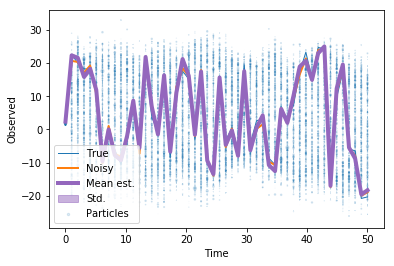

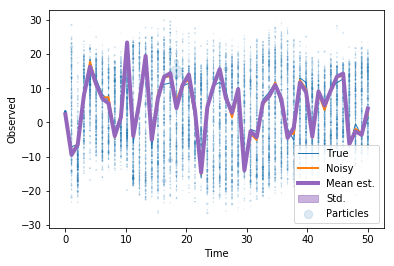

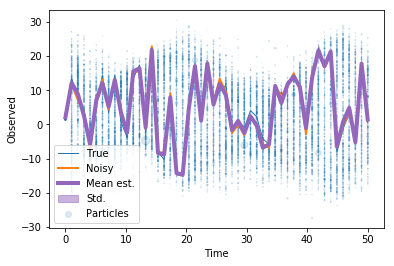

In [4]:
#Create the time serie needed for the plot and the filter
x = np.linspace(0, T, T)
ts = [{"t":t} for t in x]

for i in range(n_samples):
    filter_plot(x, z[i], obs[i], pf, inputs=ts)

In [5]:
#Testing the particle filter with random dropouts

T2=50
n_samples2=3

(z2,obs2,x2)= samplePFSequence(pf, T2, n_samples2)
pf_est = ParticleFilterEstimator()
mask2 = np.zeros(obs2.shape)

#Creating the random mask
for i in range(n_samples2):
    test = np.reshape(randomSigma(T2, p0=0.9)[0],(T,1)) # 90% chance of 0 or 10% of dropouts
    mask2[i] = test
    

#add mask to obs
masked_obs2 = np.ma.array(obs2, mask = mask2)

est = pf_est.estimateAll(masked_obs2)

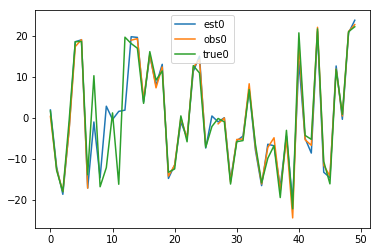

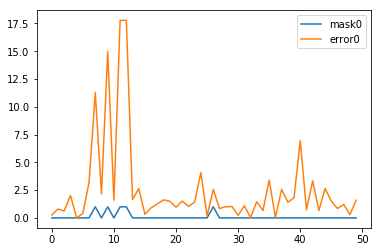

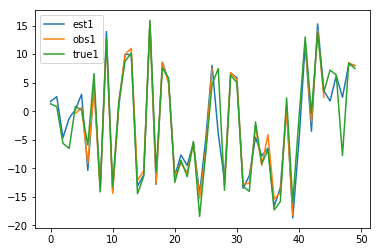

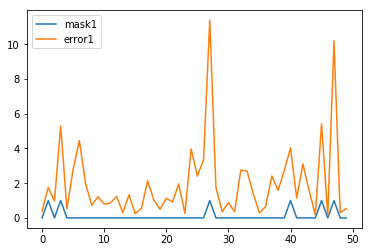

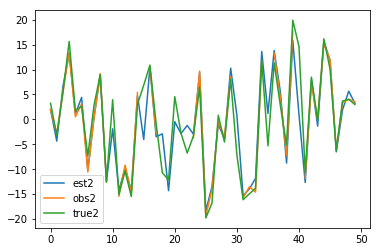

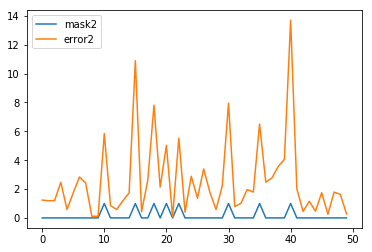

In [6]:
dim=0
for n in range(n_samples2):
    pyplot.plot(est[n,:,0],label='est' + str(n))
    pyplot.plot(masked_obs2[n,:,0],label='obs' + str(n))
    pyplot.plot(z2[n,:,0],label='true' + str(n))
    pyplot.legend()
    pyplot.show()
    
    mask = np.ma.getmask(masked_obs2[n,:,0])
    error = abs(est[n,:,0] - z2[n,:,0])
    pyplot.plot(mask ,label='mask' + str(n))
    pyplot.plot(error ,label='error' + str(n))
    pyplot.legend()
    pyplot.show()

C:\Users\natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


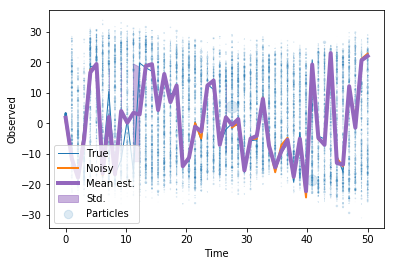

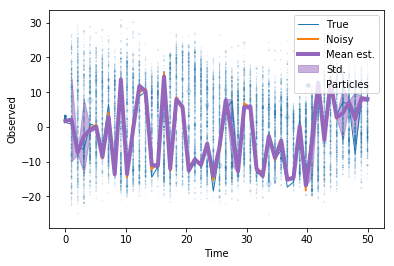

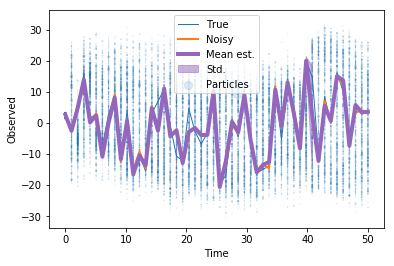

In [7]:
x = np.linspace(0, T2, T2)
ts = [{"t":t} for t in x]

for i in range(n_samples2):
    filter_plot(x, z2[i], masked_obs2[i], pf_est._pf, inputs=ts)

In [8]:

pf_est.reset()
estimate = pf_est.estimate(masked_obs2[0][0])


In [9]:
print(estimate)
print(masked_obs2[0][0])

[2.03745626]
[0.41394986649986376]


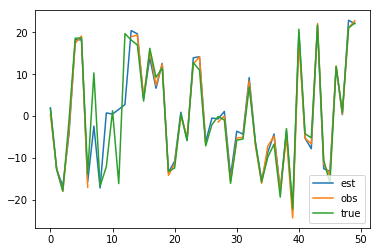

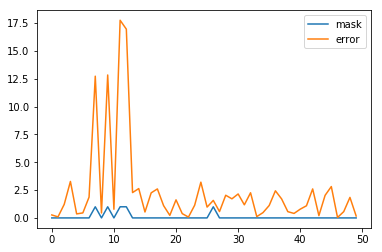

In [28]:
#Test PFFilterOne

pf_est.reset()
est = np.zeros(T)
for i in range(T):
    est[i] = pf_est.estimate(masked_obs2[0][i])

pyplot.plot(est,label='est')
pyplot.plot(masked_obs2[0,:,0],label='obs')
pyplot.plot(z2[0,:,0],label='true')
pyplot.legend()
pyplot.show()

mask = np.ma.getmask(masked_obs2[0,:,0])
error = abs(est - z2[0,:,0])

pyplot.plot(mask ,label='mask')
pyplot.plot(error ,label='error')
pyplot.legend()
pyplot.show()

In [11]:
print(est[0])

[1.72032593]
